In [355]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
#register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [356]:
# !wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv

In [357]:
df2 = pd.read_csv('../data/OxCGRT_USA_latest.csv')
df2.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C1M_Flag,C2M_Workplace closing,C2M_Flag,...,MajorityVaccinated,PopulationVaccinated,StringencyIndex_Average,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex,EconomicSupportIndex_ForDisplay
0,United States,USA,NaN,NaN,NAT_TOTAL,20200101,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United States,USA,NaN,NaN,NAT_TOTAL,20200102,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United States,USA,NaN,NaN,NAT_TOTAL,20200103,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,United States,USA,NaN,NaN,NAT_TOTAL,20200104,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United States,USA,NaN,NaN,NAT_TOTAL,20200105,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [358]:
#df2 = df2['CountryName' == 'United States']
df2 = df2[df2['CountryName'] == 'United States']
df2 = df2[df2['Jurisdiction'] == 'NAT_TOTAL']
print(df2.shape)

# remove some columns V2B_Vaccine age eligibility/availability age floor (general population summary)
df2 = df2.drop(['CountryName', 'CountryCode', 'RegionName', 'RegionCode', 'Jurisdiction', 'Date'], axis=1)
df2 = df2.drop(['V2B_Vaccine age eligibility/availability age floor (general population summary)','V2C_Vaccine age eligibility/availability age floor (at risk summary)','MajorityVaccinated'], axis=1)


df2 = df2.iloc[76:, :]
df2 = df2.reset_index(drop=True)
df2.head()

(1096, 61)


,C1M_School closing,C1M_Flag,C2M_Workplace closing,C2M_Flag,C3M_Cancel public events,C3M_Flag,C4M_Restrictions on gatherings,C4M_Flag,C5M_Close public transport,C5M_Flag,...,ConfirmedDeaths,PopulationVaccinated,StringencyIndex_Average,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex,EconomicSupportIndex_ForDisplay
0,3.0,0.0,0.0,NaN,2.0,0.0,2.0,0.0,1.0,0.0,...,134.0,0.0,55.09,55.09,42.19,42.19,48.21,48.21,0.0,0.0
1,3.0,0.0,0.0,NaN,2.0,0.0,2.0,0.0,1.0,0.0,...,194.0,0.0,55.09,55.09,42.19,42.19,48.21,48.21,0.0,0.0
2,3.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,...,266.0,0.0,67.13,67.13,48.96,48.96,55.95,55.95,0.0,0.0
3,3.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,...,372.0,0.0,67.13,67.13,48.96,48.96,55.95,55.95,0.0,0.0
4,3.0,0.0,3.0,0.0,2.0,0.0,4.0,0.0,1.0,0.0,...,475.0,0.0,72.69,72.69,52.08,52.08,59.52,59.52,0.0,0.0


In [359]:
df = pd.read_csv('../data/time_series_covid19_confirmed_US.csv')
df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,19732,19759,19759,19759,19759,19759,19759,19759,19790,19790
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,69641,69767,69767,69767,69767,69767,69767,69767,69860,69860
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,7451,7474,7474,7474,7474,7474,7474,7474,7485,7485
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,8067,8087,8087,8087,8087,8087,8087,8087,8091,8091
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,18616,18673,18673,18673,18673,18673,18673,18673,18704,18704


In [360]:
df = df.iloc[:, 11:]
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,0,0,0,0,0,0,0,0,0,0,...,19732,19759,19759,19759,19759,19759,19759,19759,19790,19790
1,0,0,0,0,0,0,0,0,0,0,...,69641,69767,69767,69767,69767,69767,69767,69767,69860,69860
2,0,0,0,0,0,0,0,0,0,0,...,7451,7474,7474,7474,7474,7474,7474,7474,7485,7485
3,0,0,0,0,0,0,0,0,0,0,...,8067,8087,8087,8087,8087,8087,8087,8087,8091,8091
4,0,0,0,0,0,0,0,0,0,0,...,18616,18673,18673,18673,18673,18673,18673,18673,18704,18704


In [361]:
df.isnull().sum().sum()

0

In [362]:
daily_cases = df.sum(axis=0)

daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases = daily_cases[:-47]
daily_cases.reset_index(drop=True, inplace=True)



#df2.index = pd.to_datetime(df2.index)

daily_cases = pd.concat([daily_cases, df2['C2M_Workplace closing']], axis=1)
add_index = 1
# replace Nan with 0
daily_cases = daily_cases.fillna(0)
daily_cases_index = pd.date_range(start='2020-01-22', periods=len(daily_cases), freq='D')
daily_cases.index = daily_cases_index

daily_cases.head()

,0,C2M_Workplace closing
2020-01-22,1,0.0
2020-01-23,1,0.0
2020-01-24,2,3.0
2020-01-25,2,3.0
2020-01-26,5,3.0


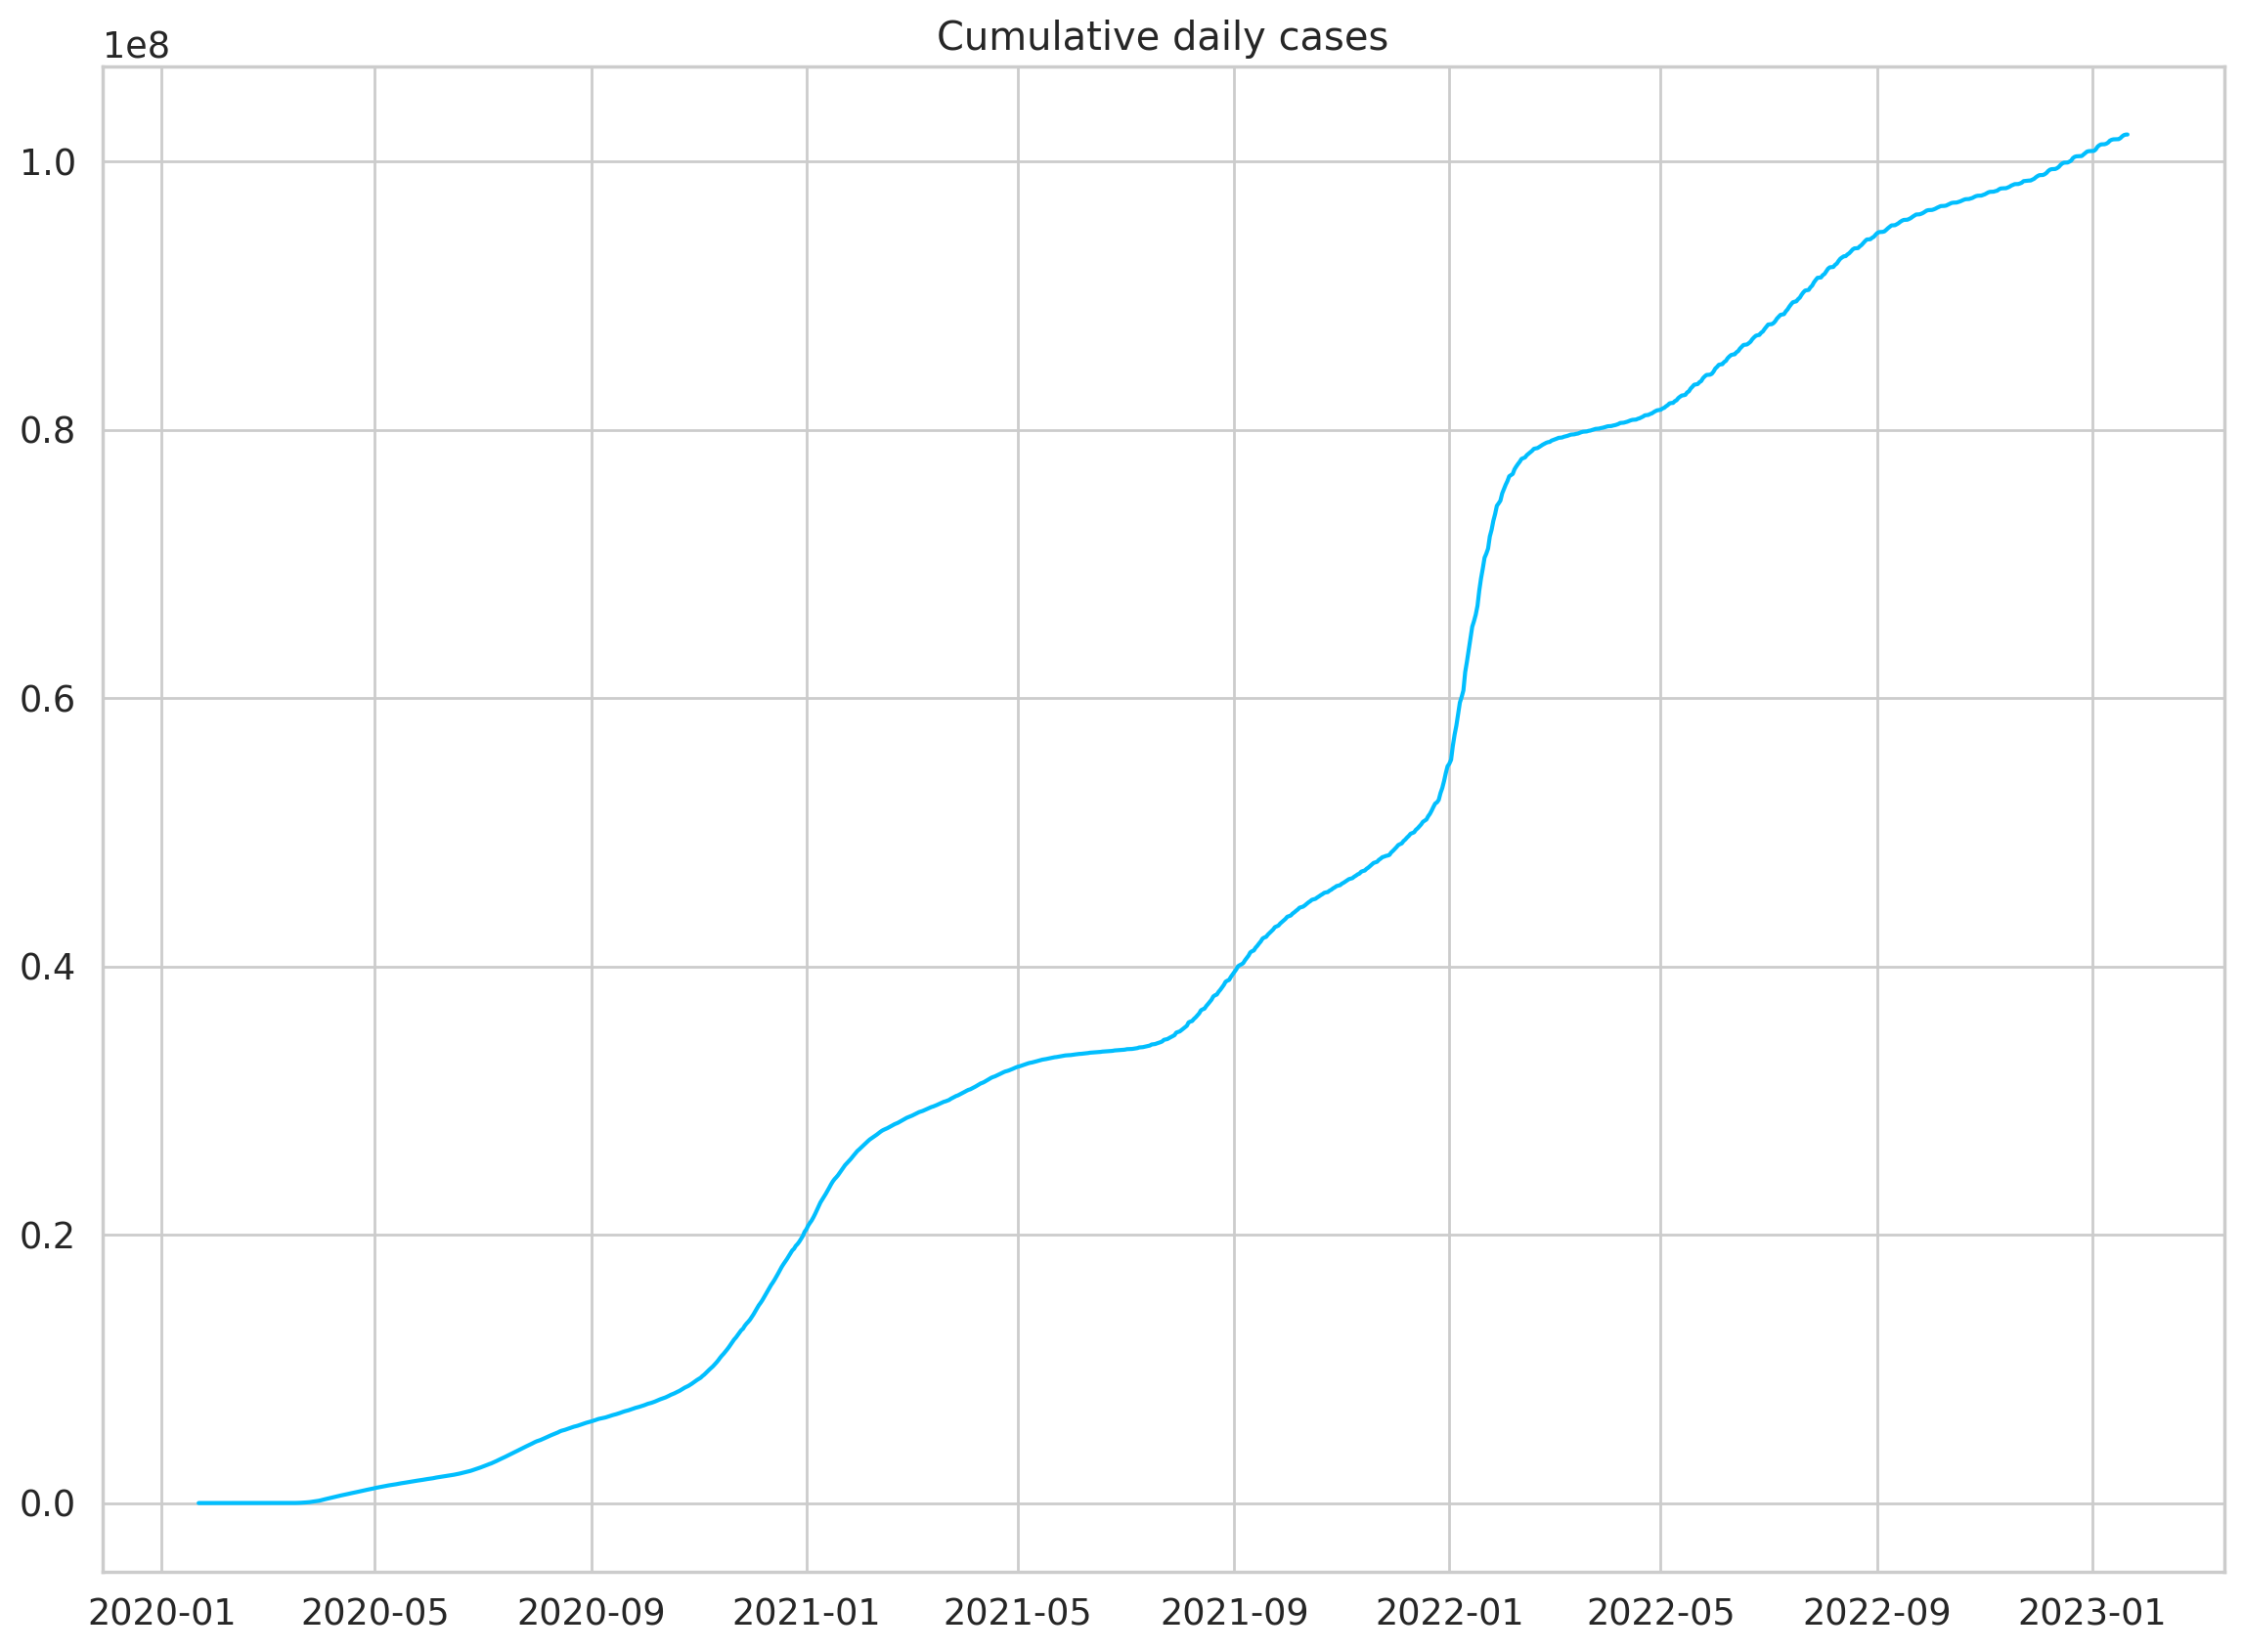

In [363]:
plt.plot(daily_cases[0])
plt.title("Cumulative daily cases");

In [364]:
daily_cases[0] = daily_cases[0].diff().fillna(daily_cases[0])

# do a mean to smooth the data
daily_cases[0] = daily_cases[0].rolling(window=7).mean()

# replace Nan with 0
daily_cases = daily_cases.fillna(0)

daily_cases.astype(np.float32)
daily_cases.head()

,0,C2M_Workplace closing
2020-01-22,0.0,0.0
2020-01-23,0.0,0.0
2020-01-24,0.0,3.0
2020-01-25,0.0,3.0
2020-01-26,0.0,3.0


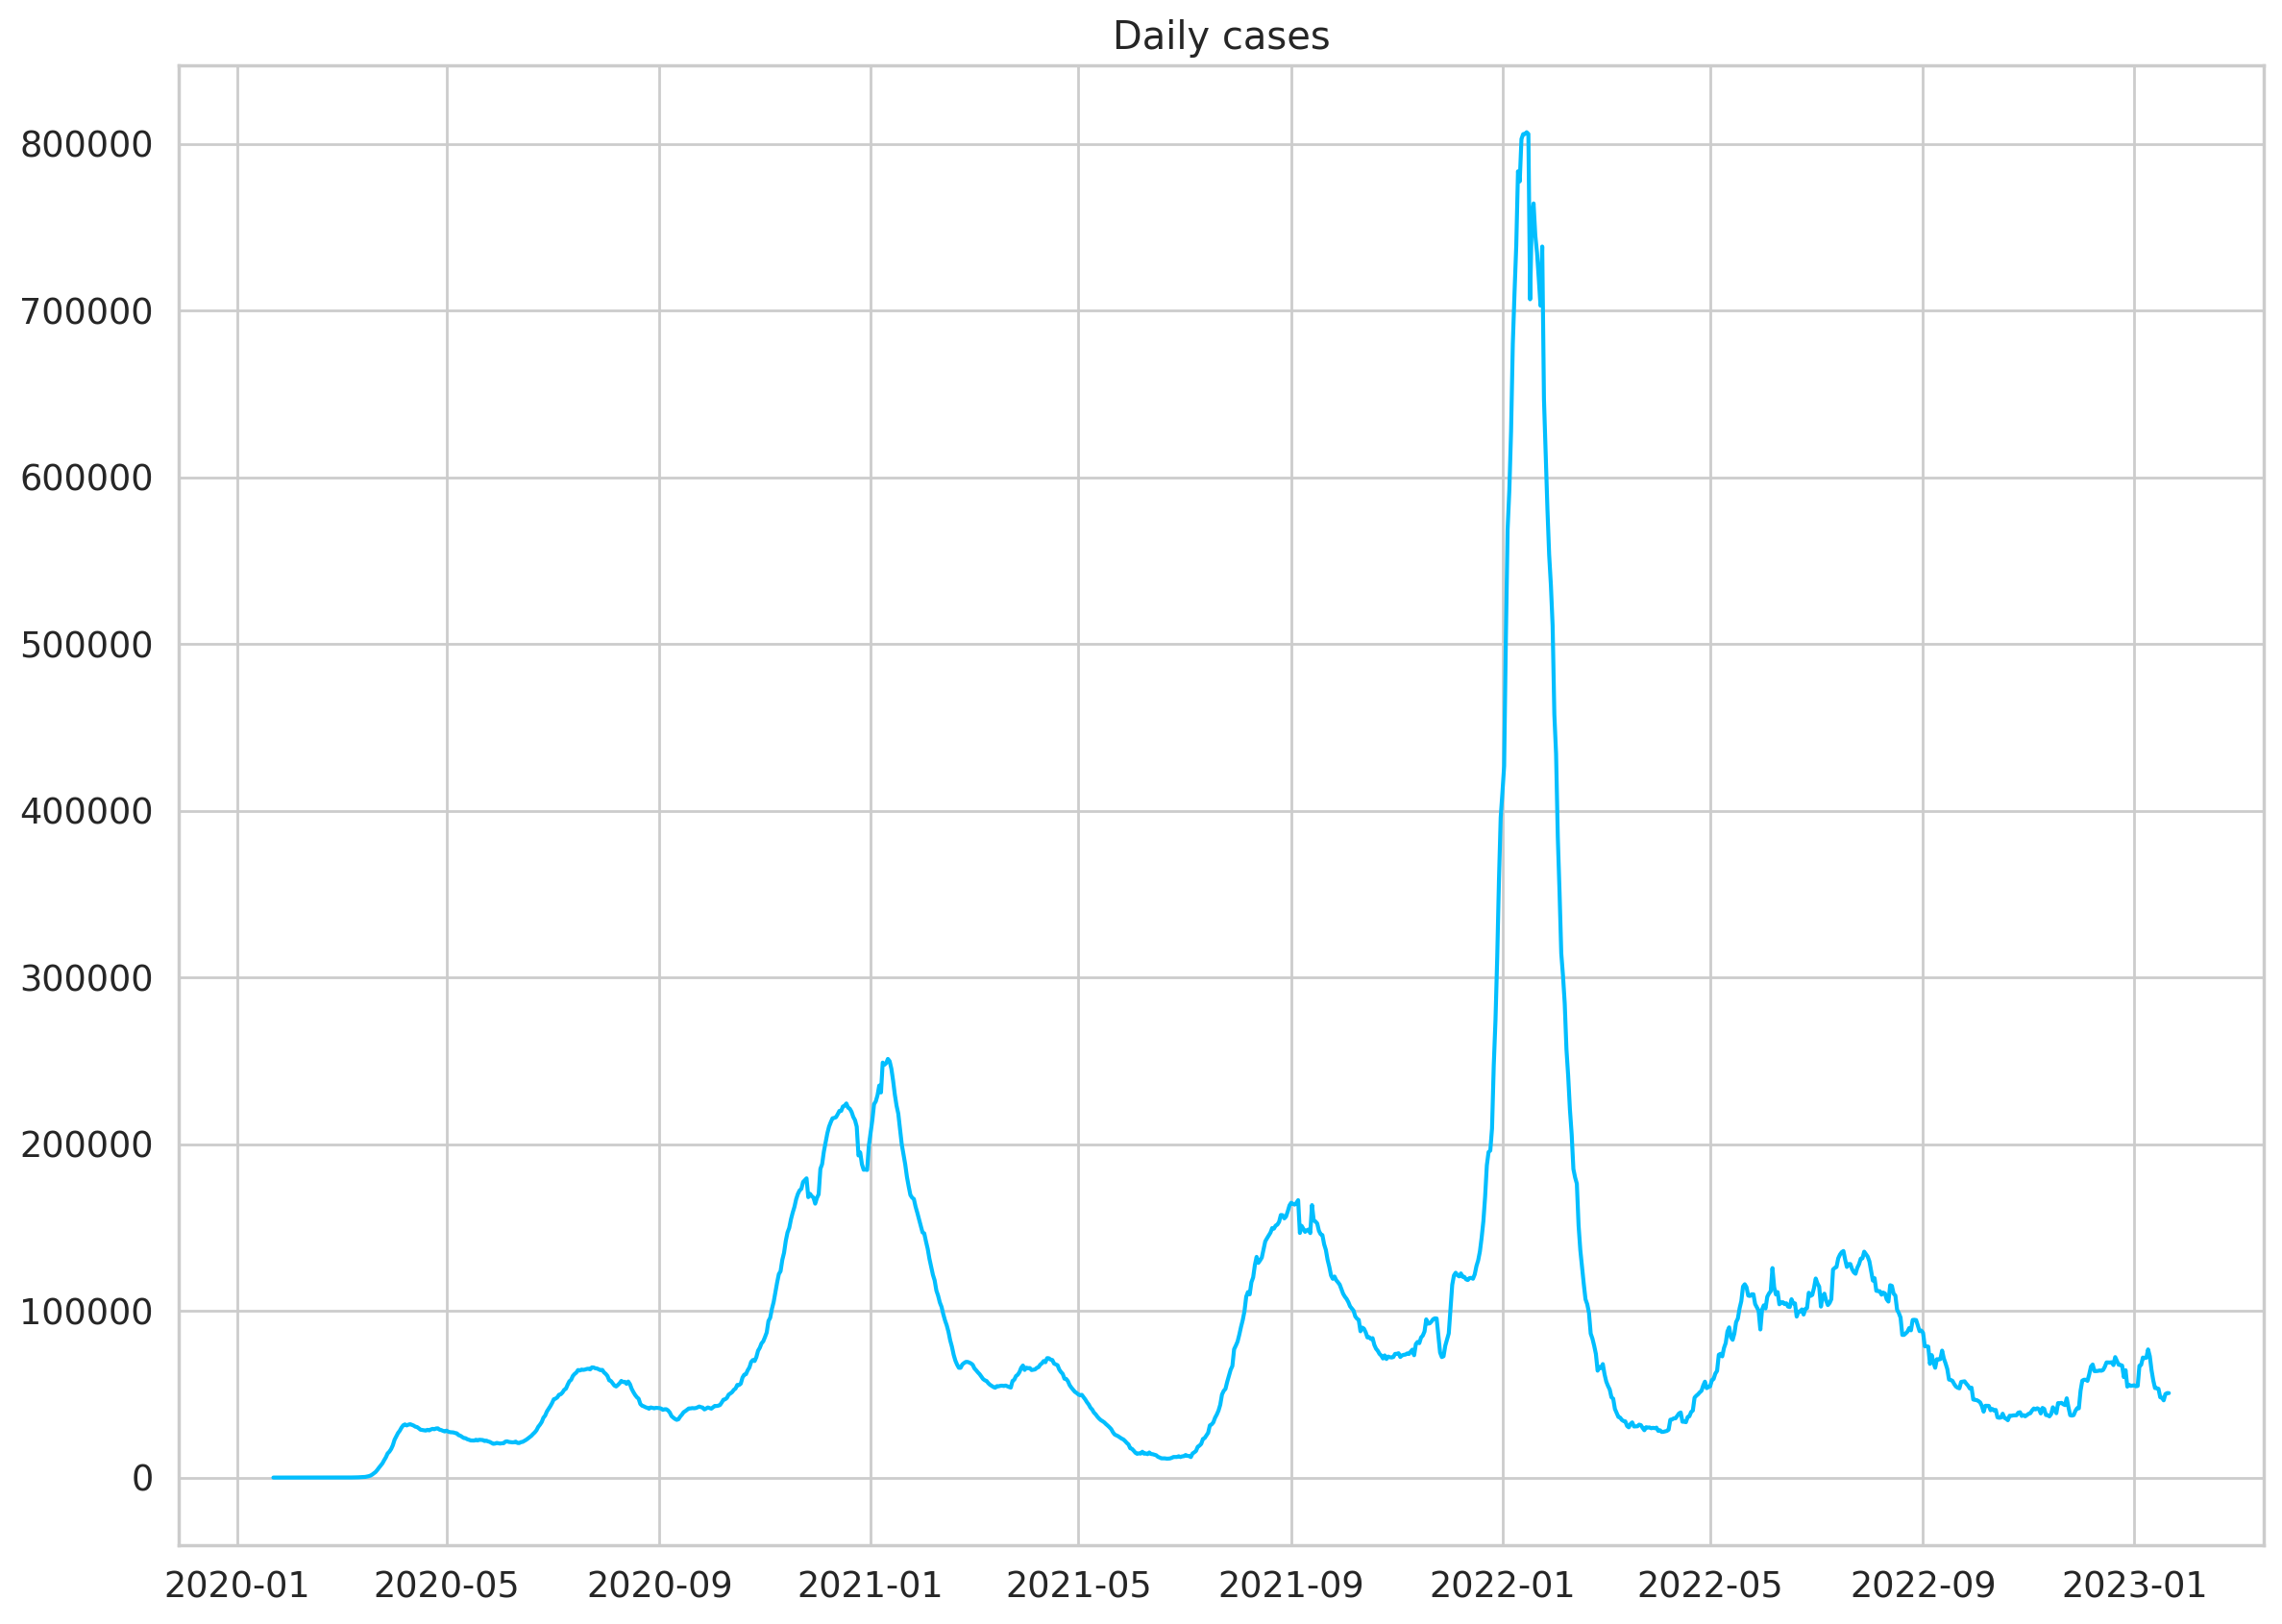

In [365]:
plt.plot(daily_cases[0])
plt.title("Daily cases");

In [366]:
days = daily_cases.shape[0]

print('We have data for ' + str(days))

We have data for 1096


In [367]:
test_data_size = 200

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size-5:]

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print(train_data.shape)
print(test_data.shape)

(896, 2)
(205, 2)


In [368]:
scaler = RobustScaler()
train_data = train_data.values
test_data = test_data.values
scaler = scaler.fit(train_data)

train_data = scaler.transform(train_data)

test_data = scaler.transform(test_data)

In [369]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [370]:
seq_length = 14

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [371]:
X_train.shape

torch.Size([881, 14, 2])

In [372]:
X_train[:2]

tensor([[[-0.7545, -2.0000],
         [-0.7545, -2.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000]],

        [[-0.7545, -2.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000],
         [-0.7545,  1.0000]]])

In [373]:
y_train.shape

torch.Size([881, 2])

In [374]:
y_train[:2]

tensor([[-0.7545,  1.0000],
        [-0.7545,  1.0000]])

In [375]:
train_data[:10]

array([[-0.7545204 , -2.        ],
       [-0.7545204 , -2.        ],
       [-0.7545204 ,  1.        ],
       [-0.7545204 ,  1.        ],
       [-0.7545204 ,  1.        ],
       [-0.7545204 ,  1.        ],
       [-0.75451199,  1.        ],
       [-0.75451199,  1.        ],
       [-0.75451199,  1.        ],
       [-0.7545103 ,  1.        ]])

In [376]:

class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(self.device),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(self.device)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
        sequences.view(len(sequences), self.seq_len, -1),
        self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [377]:

def train_model(model,train_data_, train_labels_, test_data_ = None, test_labels_ = None):
  loss_fn = torch.nn.MSELoss(reduction='mean')

  optimiser = torch.optim.AdamW(model.parameters(), lr=1e-3)
  scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.8)
  num_epochs = 100

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)
  tbar = tqdm(range(num_epochs))
  for t in tbar:
    model.reset_hidden_state()

    y_pred = model(train_data_)

    loss = loss_fn(y_pred.float(), train_labels_)

    if test_data_ is not None:
      with torch.no_grad():
        y_test_pred = model(test_data_)
        test_loss = loss_fn(y_test_pred.float(), test_labels_)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        tbar.set_description(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      tbar.set_description(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
    scheduler.step()

  return model.eval(), train_hist, test_hist

In [378]:
model = CoronaVirusPredictor(
  n_features=add_index+1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
model = model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train[:,0].reshape(-1,1), 
  X_test, 
  y_test[:,0].reshape(-1,1)
)

Using cuda device


Epoch 90 train loss: 1.9909533262252808 test loss: 0.1489328145980835: 100%|██████████| 100/100 [00:21<00:00,  4.56it/s]


the train and test loss:

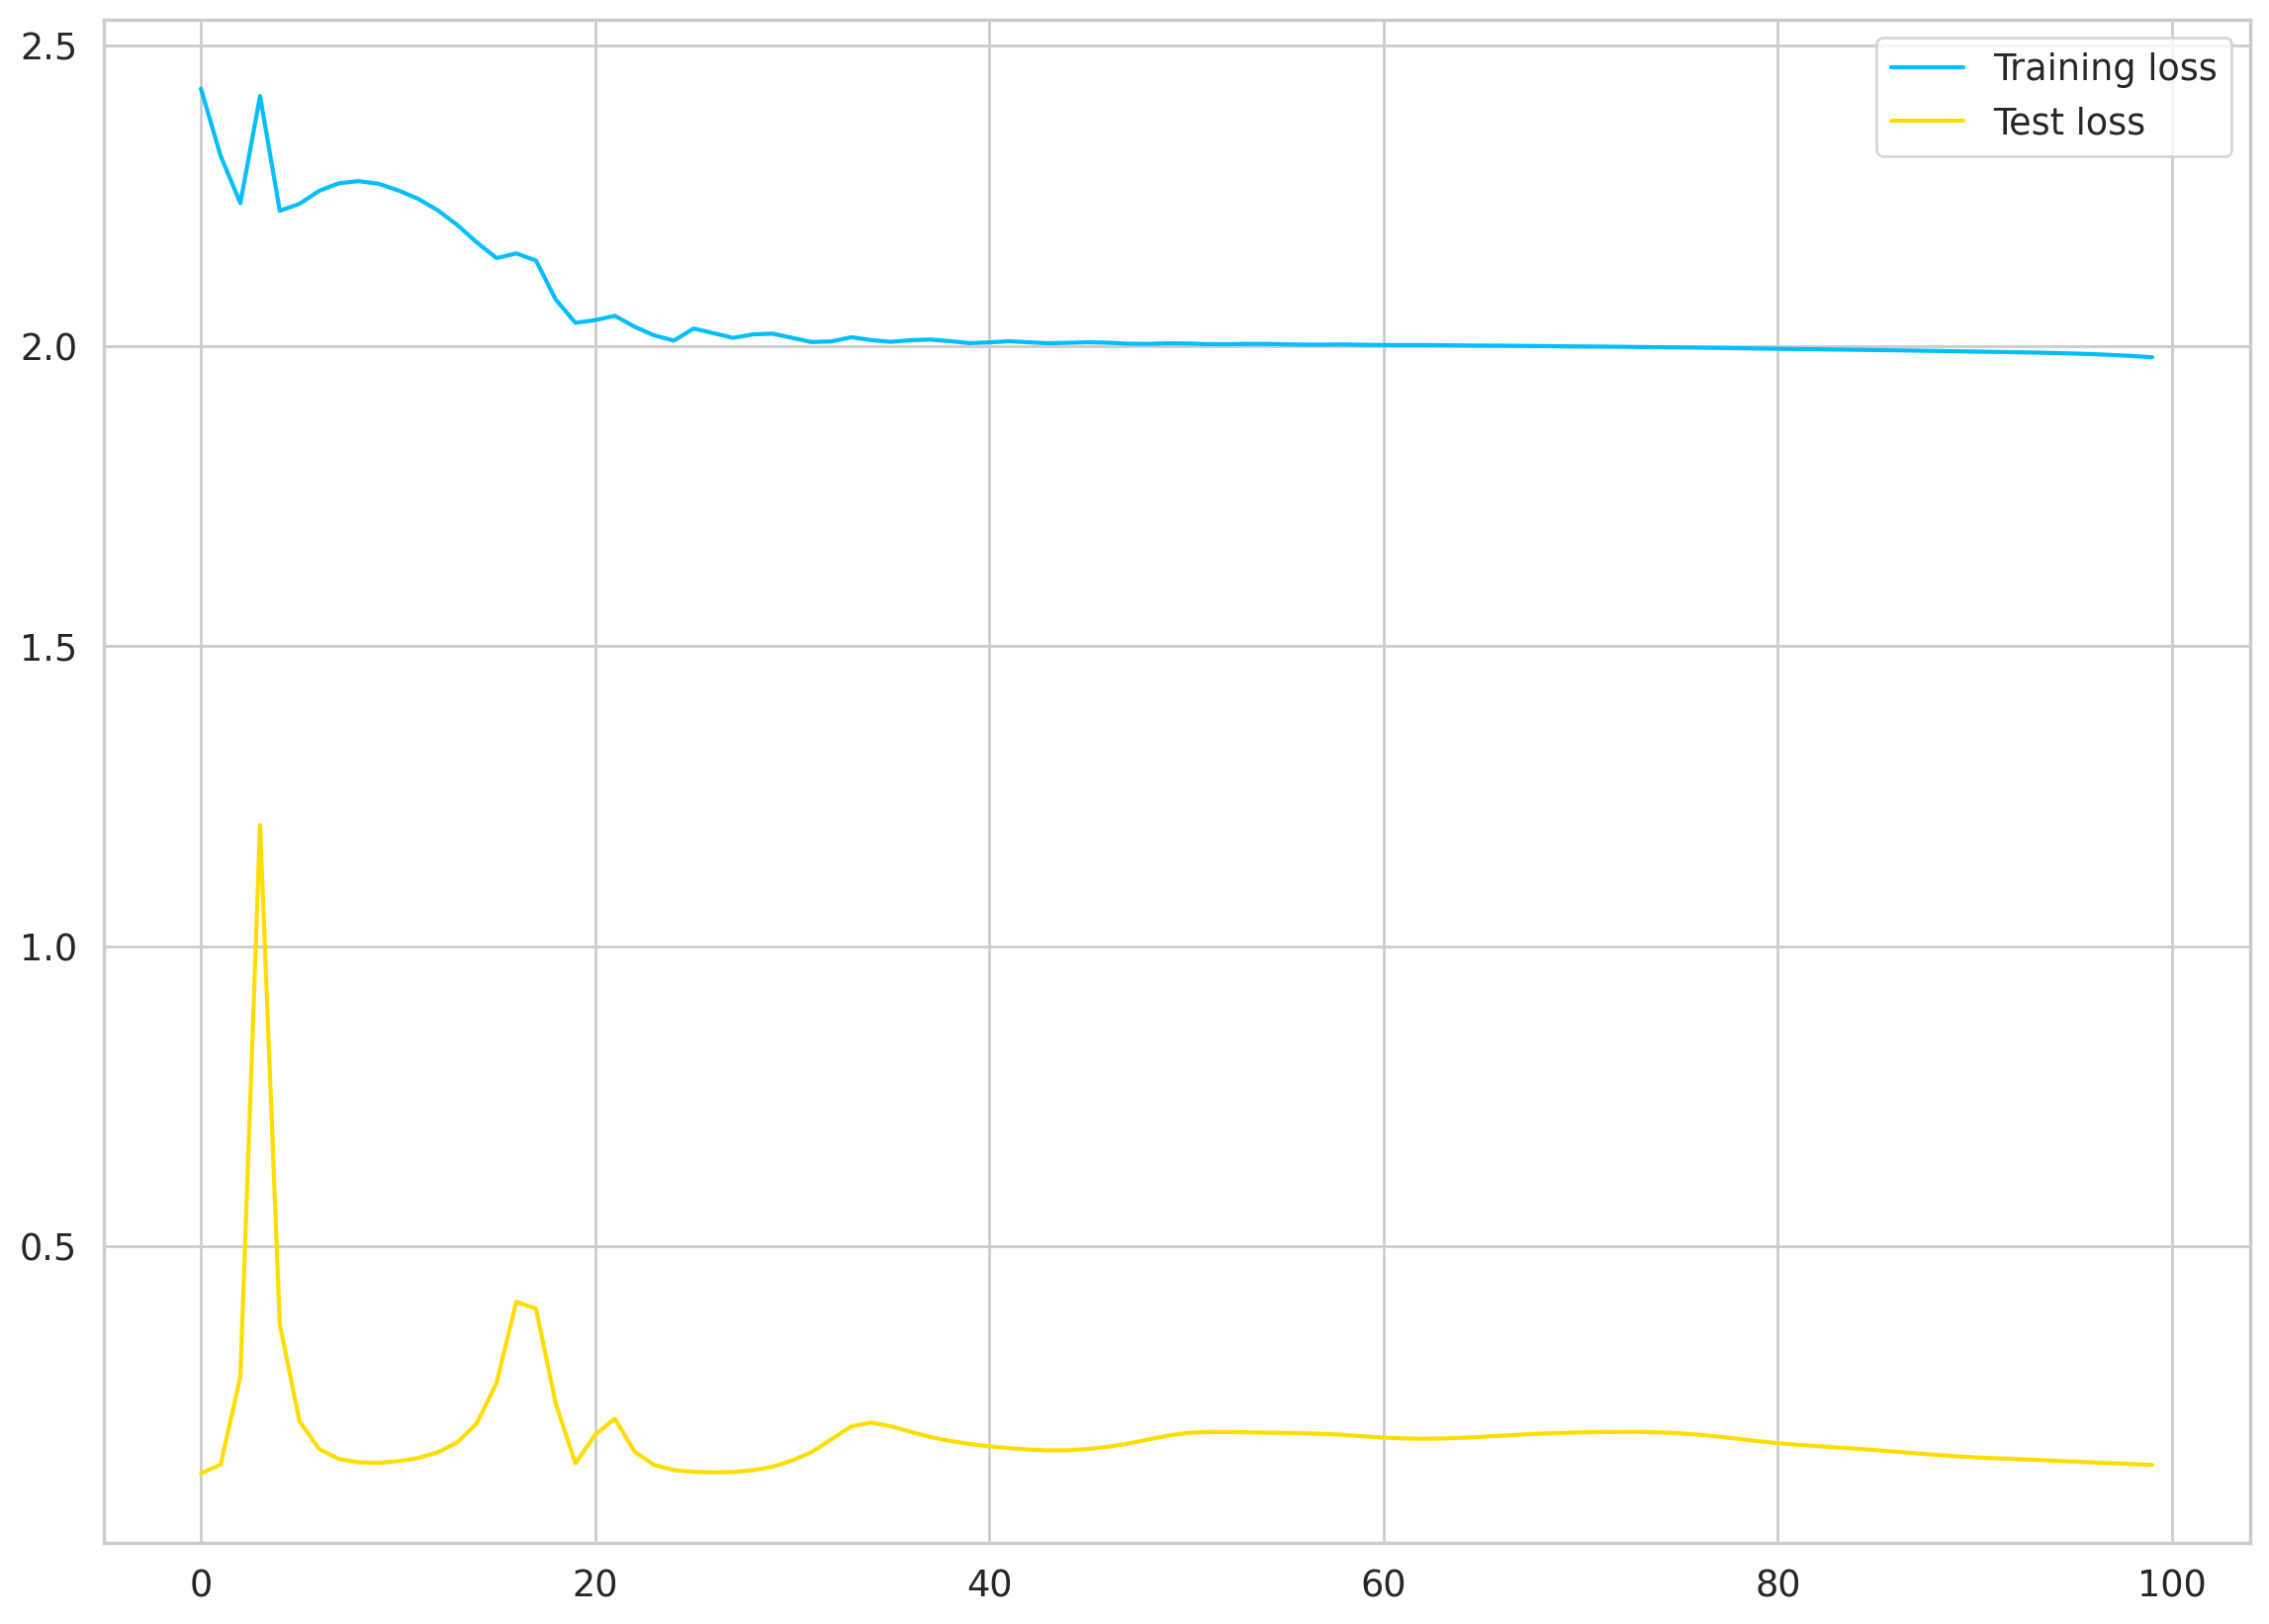

In [379]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
#plt.ylim((0, 55))
plt.legend();

In [380]:
with torch.no_grad():
  preds = []
  for _ in range(len(X_test)):
    test_seq = X_test[_].view(1, seq_length, add_index+1).float()
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    
print(preds)

[-0.12493376433849335, 0.004547632299363613, 0.16370132565498352, 0.3169959485530853, 0.4404926300048828, 0.5310719013214111, 0.6018127799034119, 0.6622716784477234, 0.7151155471801758, 0.7625074982643127, 0.8062721490859985, 0.851489782333374, 0.8996050357818604, 0.9521274566650391, 1.0067909955978394, 1.0655370950698853, 1.1246339082717896, 1.181750774383545, 1.2344306707382202, 1.2786484956741333, 1.3123388290405273, 1.3409234285354614, 1.3598757982254028, 1.372822880744934, 1.3823448419570923, 1.388161063194275, 1.3929660320281982, 1.3968148231506348, 1.3969417810440063, 1.3934422731399536, 1.3967392444610596, 1.4043124914169312, 1.410125732421875, 1.4133762121200562, 1.407133936882019, 1.3930015563964844, 1.3717418909072876, 1.3368500471115112, 1.2936521768569946, 1.2469847202301025, 1.2002320289611816, 1.1563994884490967, 1.1139247417449951, 1.0787619352340698, 1.0489552021026611, 1.0224963426589966, 0.9950873255729675, 0.9639822840690613, 0.9314195513725281, 0.89759361743927, 0.

In [381]:
true_cases = scaler.inverse_transform(y_test.cpu().flatten().numpy().reshape(-1,add_index+1)).flatten()
true_cases = true_cases.reshape(-1,add_index+1)[:,0]
true_cases = true_cases[5:]

preds = np.array(preds).reshape(-1,1)
preds = np.concatenate((preds, np.zeros((preds.shape[0], add_index))), axis=1)
preds[:,1:] = y_test.cpu().numpy()[:,1:]


predicted_cases = scaler.inverse_transform(preds).flatten()
predicted_cases = predicted_cases.reshape(-1,add_index+1)[:,0]
predicted_cases = predicted_cases[5:]


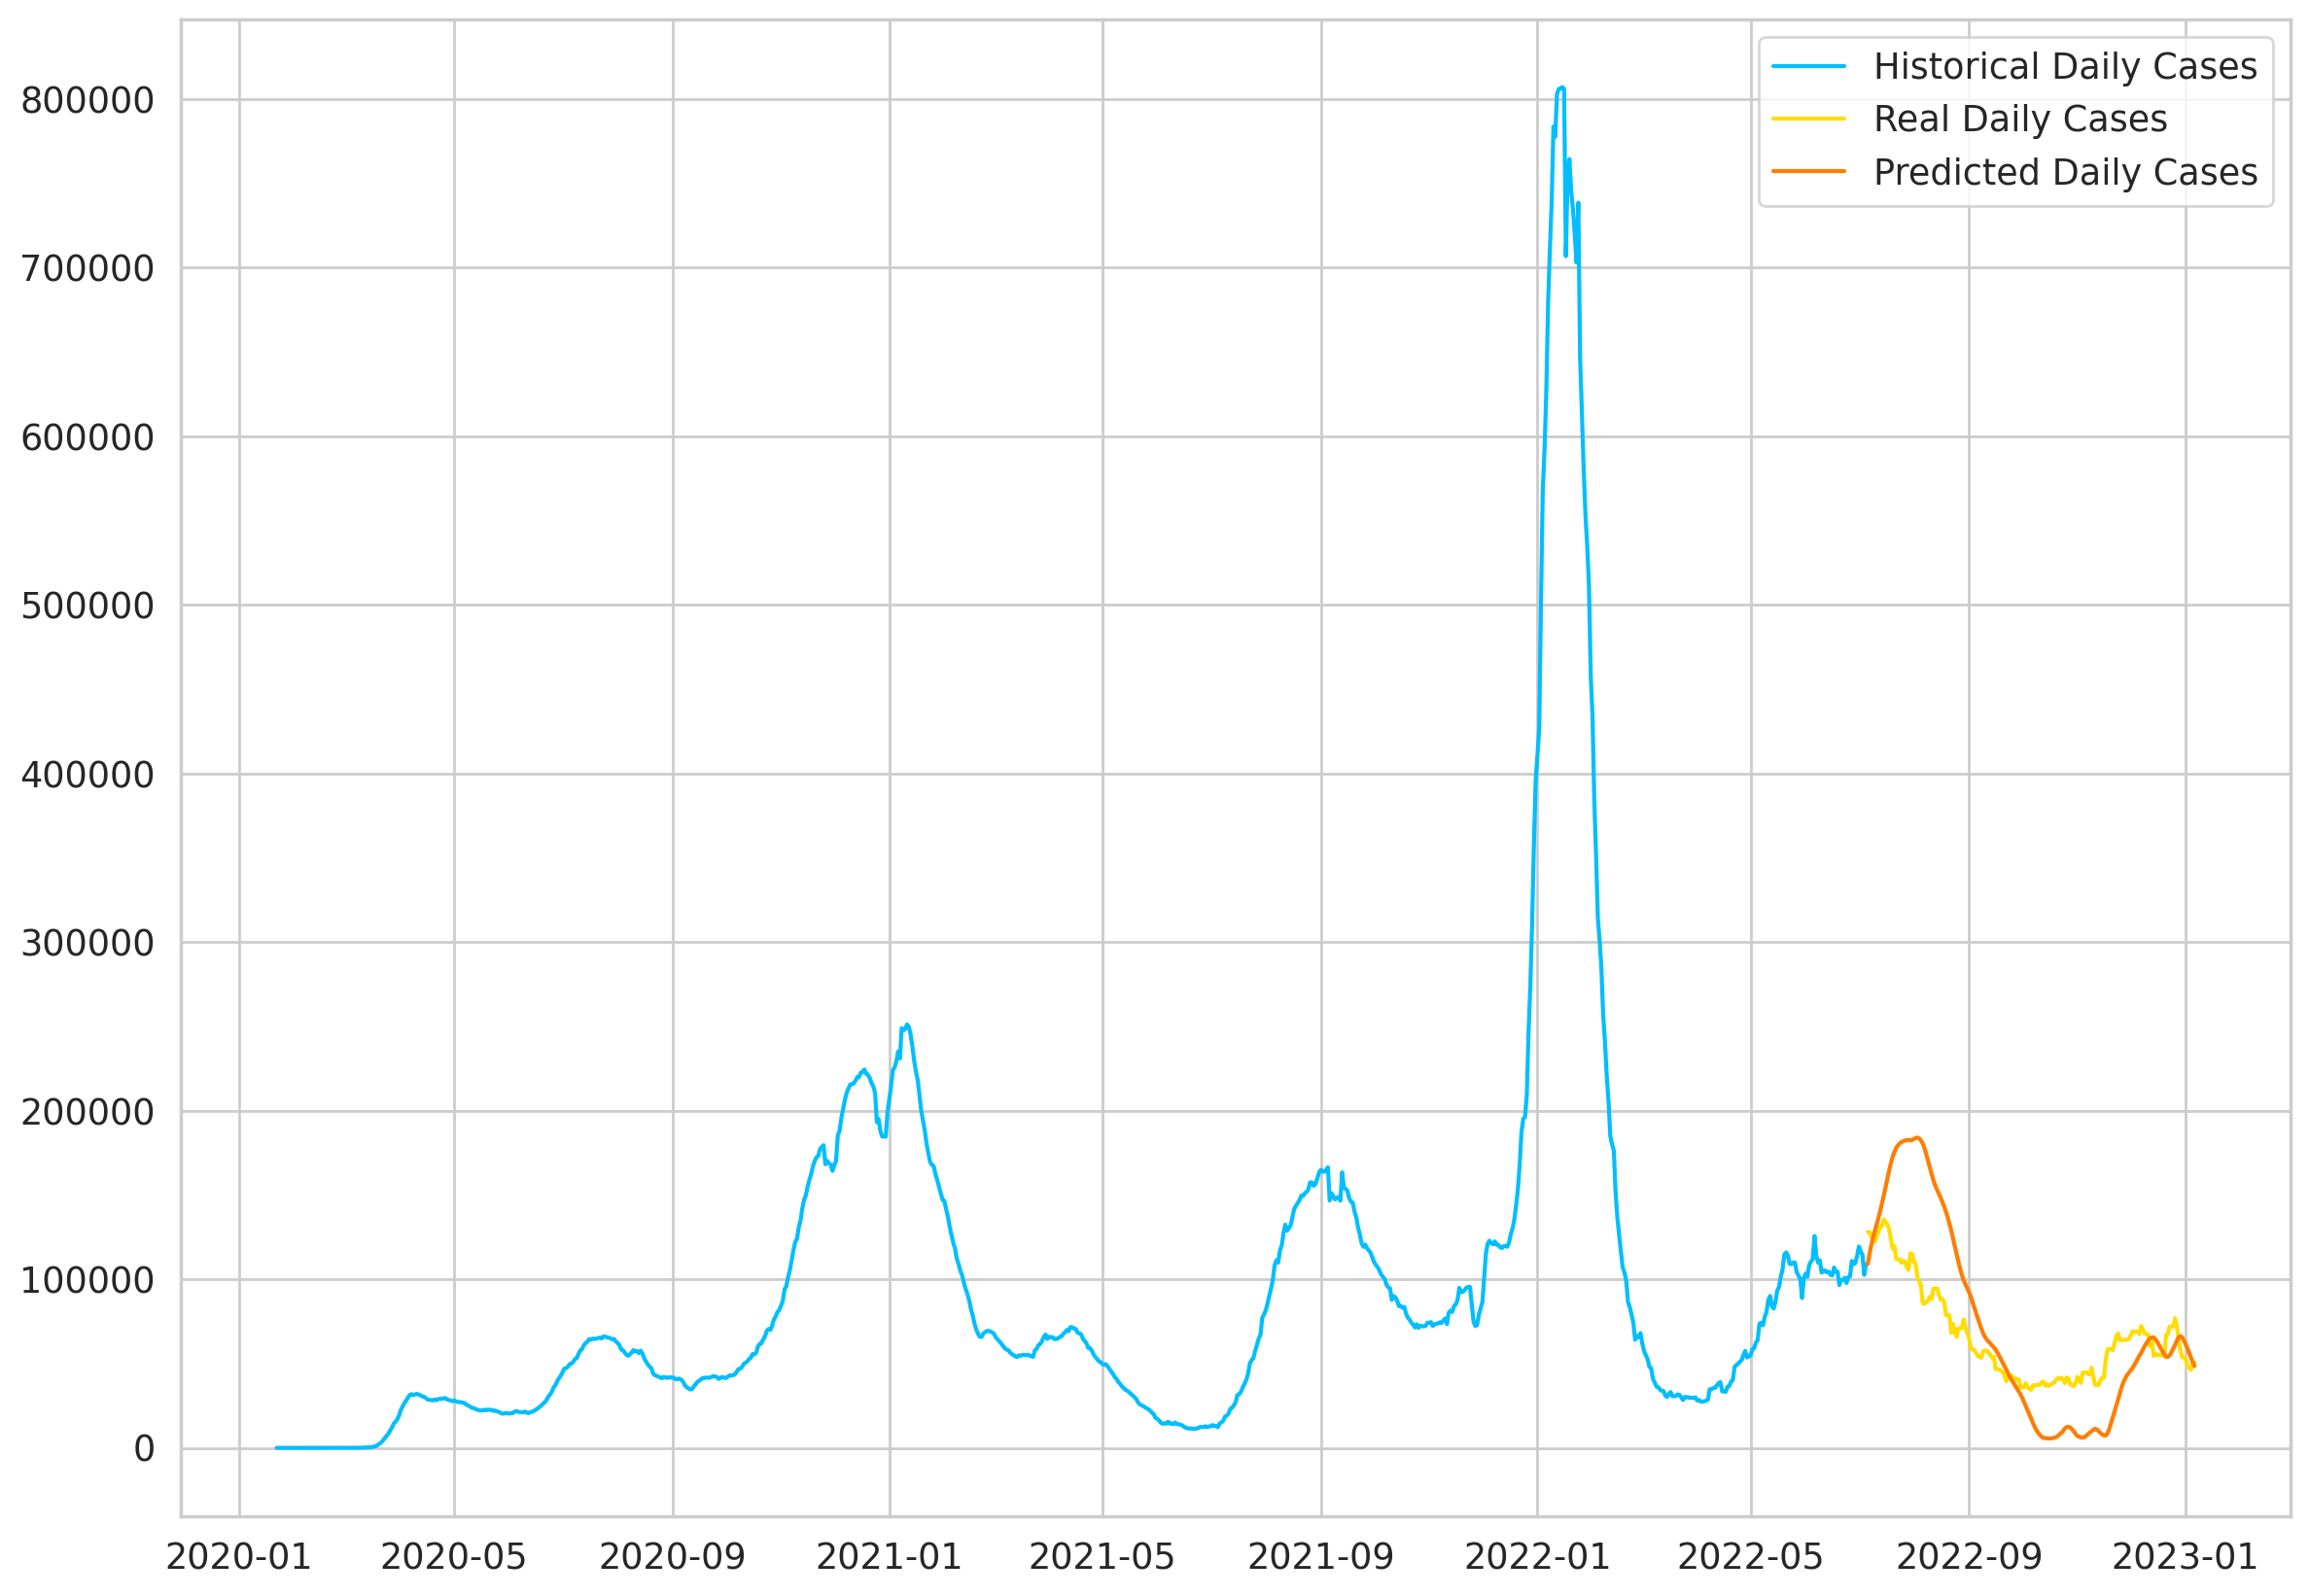

In [382]:

plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data[:].reshape(-1,add_index+1))[:,0].flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

In [383]:
scaler = MinMaxScaler()
#daily_cases = daily_cases.values
scaler = scaler.fit(daily_cases.values)

all_data = scaler.transform(daily_cases.values)

all_data.shape

(1096, 2)

In [384]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

X_all = X_all.to(device)
y_all = y_all.to(device)

model = CoronaVirusPredictor(
  n_features=add_index+1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=3
)
model = model.to(device)
model, train_hist, _ = train_model(model, X_all, y_all[:,0].reshape(-1,1))

Epoch 40 train loss: 0.019982485100626945:  49%|████▉     | 49/100 [00:18<00:19,  2.65it/s]

In [ ]:
DAYS_TO_PREDICT = 100

with torch.no_grad():
  preds = []
  for i in range(DAYS_TO_PREDICT):
    y_test_pred = model(X_all[i].view(1, seq_length, add_index+1).float())
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)



In [ ]:
preds = np.array(preds).reshape(-1,1)
preds = np.concatenate((preds, np.zeros((preds.shape[0], add_index))), axis=1)
preds[:,1:] = y_all.cpu().numpy()[:DAYS_TO_PREDICT,1:]

predicted_cases = scaler.inverse_transform(preds).flatten()
predicted_cases = predicted_cases.reshape(-1,add_index+1)[:,0]

In [ ]:
daily_cases.index[-1]

1095

/tmp/ipykernel_5785/1401313773.py:1: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


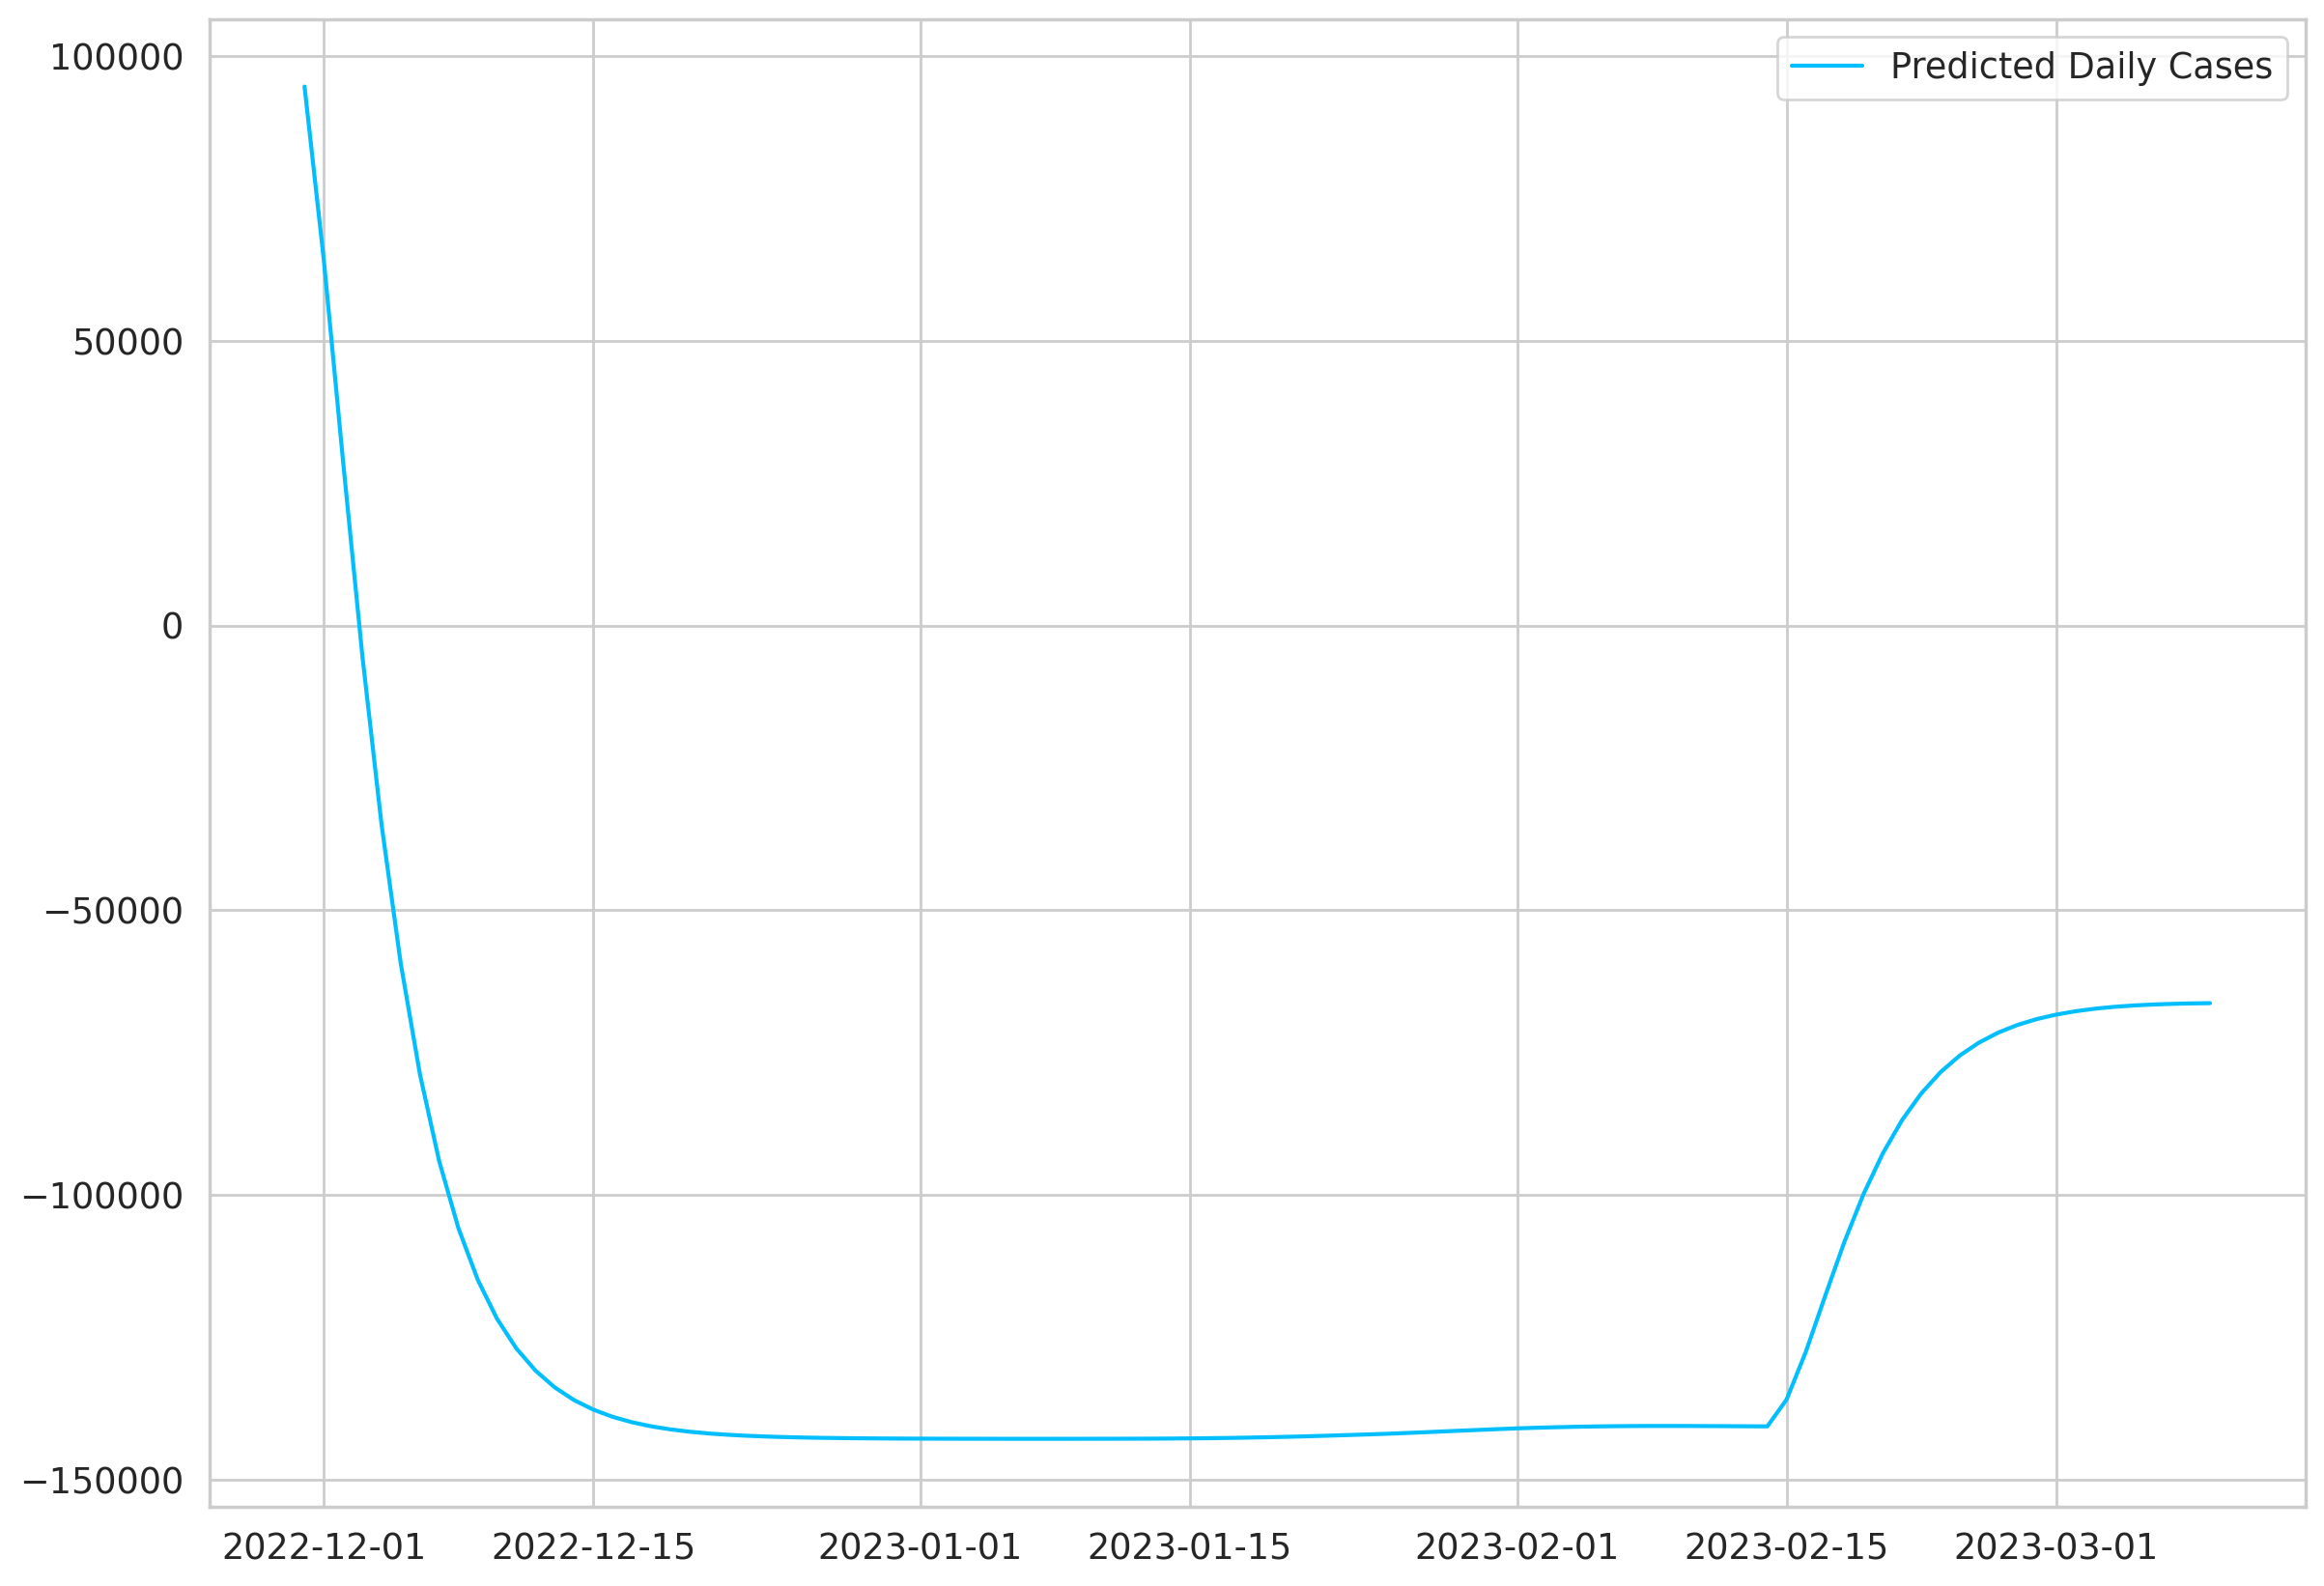

In [ ]:
predicted_index = pd.date_range(
  end= '2023-03-09',
  periods=DAYS_TO_PREDICT ,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

/tmp/ipykernel_5785/2227059732.py:1: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  daily_index = pd.date_range(


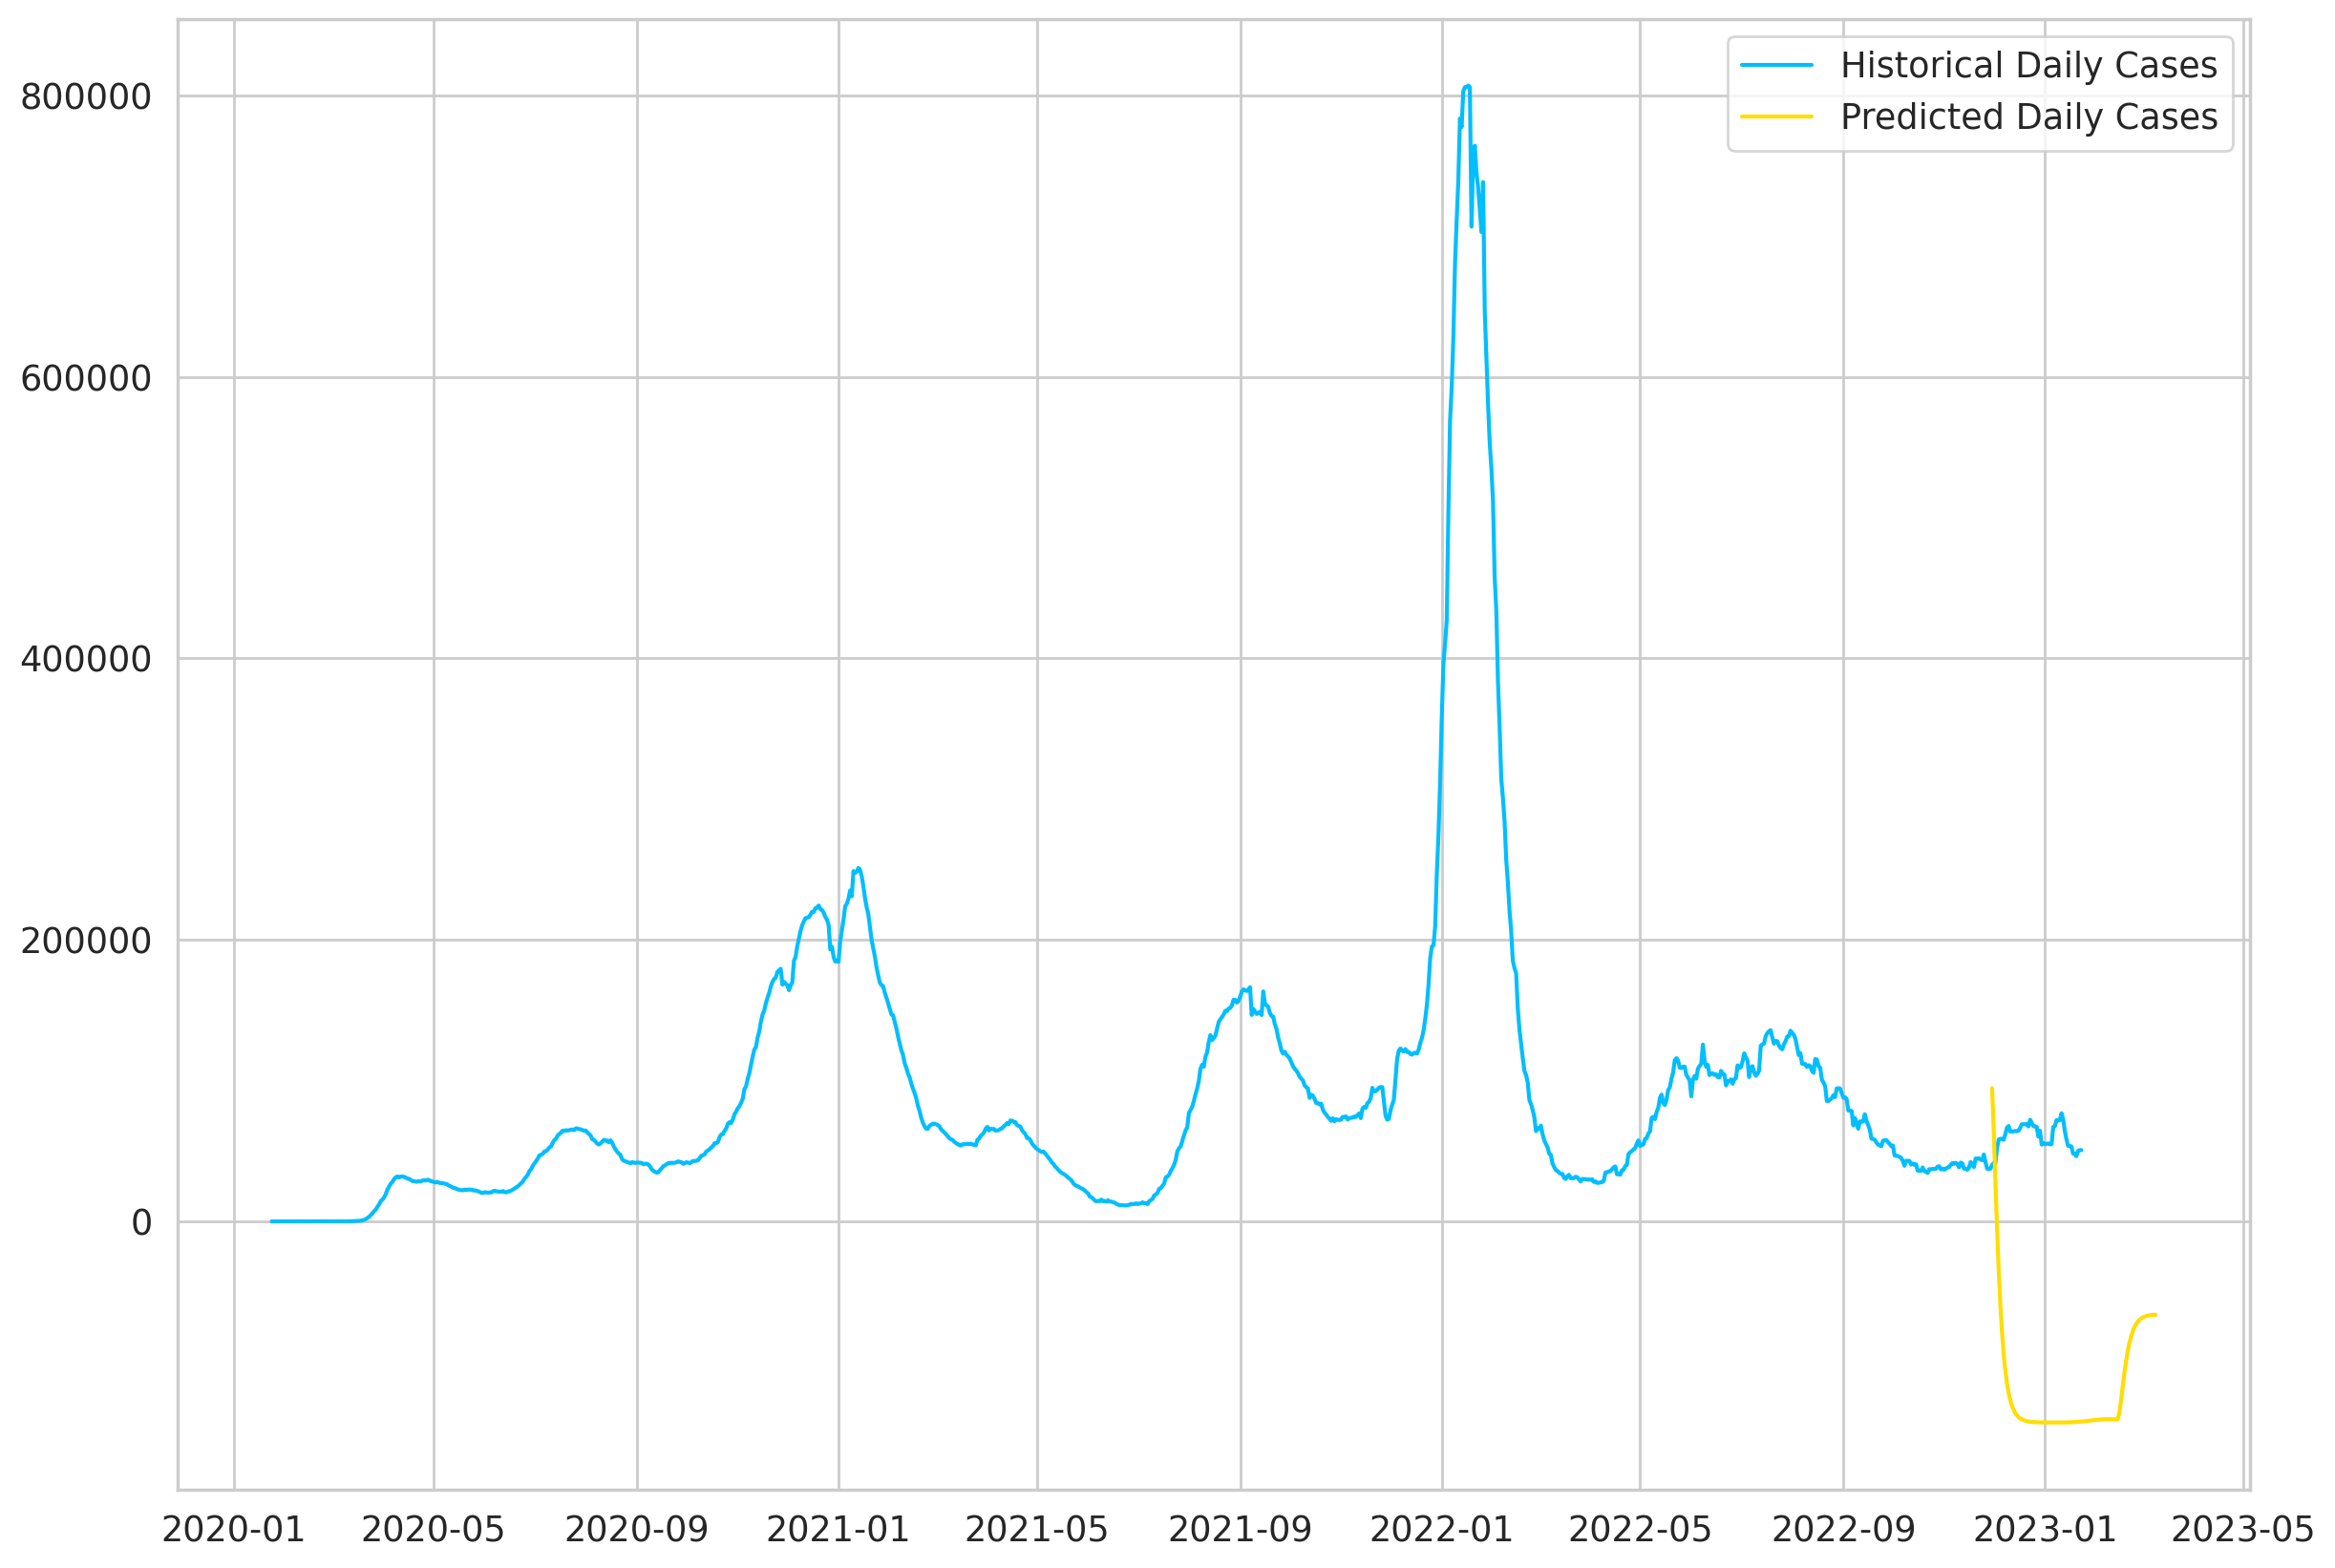

In [ ]:
daily_index = pd.date_range(
  start= '2020-01-23',
  periods=1097,
  closed='right'
)

daily_cases_2 = pd.Series(
  data=daily_cases.values[:,0],
  index=daily_index
)
plt.plot(daily_cases_2, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();